# Practice Session PS05: Recommendation engines (Content-based)

Author: <font color="blue">Alan Le Roux Osorio</font>

E-mail: <font color="blue">alan.leroux01@estudiant.upf.edu</font>

Date: <font color="blue">28/10/2025</font>

In [76]:
import pandas as pd   
import numpy as np  
import re
import matplotlib.pyplot as plt  
from math import*
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# 1. Load and join the dataset

In [77]:
# Leave this code as-is

FILENAME_MOVIES = "ml32m-movies-2000s.csv.gz"
FILENAME_RATINGS = "ml32m-ratings-2000s.csv.gz"
FILENAME_TAGS = "ml32m-tags-2000s.csv.gz"

In [78]:
# LEAVE THIS CODE AS-IS

# Load movies
movies = pd.read_csv(FILENAME_MOVIES, 
                    compression='gzip',
                    sep=',', 
                    engine='python', 
                    encoding='utf-8',
                    names=['movie_id', 'title', 'genres'])

# Remove header row from this file
movies.drop(index=0, inplace=True)

# Make sure the movie id is numeric
movies["movie_id"] = pd.to_numeric(movies["movie_id"])
display(movies.head(5))

,movie_id,title,genres
1,2769,"Yards, The (2000)",Crime|Drama
2,3177,Next Friday (2000),Comedy
3,3190,Supernova (2000),Adventure|Sci-Fi|Thriller
4,3225,Down to You (2000),Comedy|Romance
5,3228,Wirey Spindell (2000),Comedy


In [79]:
# LEAVE THIS CODE AS-IS

# Load ratings
ratings_raw = pd.read_csv(FILENAME_RATINGS, 
                    sep=',', 
                    compression='gzip',
                    encoding='utf-8',
                    engine='python',
                    names=['user_id', 'movie_id', 'rating'])
display(ratings_raw.head(5))

,user_id,movie_id,rating
0,4,223,4.0
1,4,1210,3.0
2,4,1272,4.0
3,4,1327,3.0
4,4,1513,2.0


In [80]:
#we define the function that extracts the year from the tittle, takes as input a string(the title) and returns an integer(the year)
def yearof(title):
    #use regex to search for a four digit number within parentheses and asign it to year
    year = re.search(r'\((\d{4})\)', title)
    #if a year is found, convert it to an integer, otherwise set year to 0
    if year:
        year = int(year.group(1))
    else:
        year = 0
    #return the year
    return year


In [81]:
#apply the yearof function to the title column of the movies dataframe and create a new column year with the results
#this was a hint given by the statement

movies['year'] = movies['title'].apply(yearof)
display(movies.head(5))

,movie_id,title,genres,year
1,2769,"Yards, The (2000)",Crime|Drama,2000
2,3177,Next Friday (2000),Comedy,2000
3,3190,Supernova (2000),Adventure|Sci-Fi|Thriller,2000
4,3225,Down to You (2000),Comedy|Romance,2000
5,3228,Wirey Spindell (2000),Comedy,2000


Movies_id is a common column that both dataframes have, so we can use this one to use the  pandas merge function

In [82]:

#We merge both datasets using the hint given by the statement on how to do it, above we mentioned that movie_id is a common column on both dataframes
ratings = pd.merge(ratings_raw,movies,how ='inner',on = 'movie_id')
display(ratings.head(5))

,user_id,movie_id,rating,title,genres,year
0,33,3285,4.5,"Beach, The (2000)",Adventure|Drama,2000
1,1209,3285,4.0,"Beach, The (2000)",Adventure|Drama,2000
2,1402,3285,2.0,"Beach, The (2000)",Adventure|Drama,2000
3,1411,3285,3.0,"Beach, The (2000)",Adventure|Drama,2000
4,1766,3285,2.5,"Beach, The (2000)",Adventure|Drama,2000


In [83]:

#we define a function that takes as inputs a keyword and a dataframe and prints the movie_id and title of all movies that contain
#the keyword in their title
def find_movies(keyword, movies):
    #initialize a counter to keep track of the number of movies found
    count = 0
    #we iterate over the rows of the dataframe
    for _, row in movies.iterrows():
        #we get the title of the movie
        title = row['title']
        #we check if the keyword is in the title.Tip given by the statement
        if keyword in title:
            print(f"movie_id: {row['movie_id']}, title: {title}")
            count += 1
    if count == 0:
        print("No movies found with the given keyword.")

find_movies("Matrix", movies)

movie_id: 6365, title: Matrix Reloaded, The (2003)
movie_id: 6934, title: Matrix Revolutions, The (2003)
movie_id: 132490, title: Return to Source: The Philosophy of The Matrix (2004)
movie_id: 157721, title: Armitage: Dual Matrix (2002)
movie_id: 172255, title: The Matrix Revisited (2001)
movie_id: 179489, title: The Living Matrix (2009)
movie_id: 181103, title: Matrix of Evil (2003)
movie_id: 216897, title: Sex and the Matrix (2000)
movie_id: 227534, title: The Matrix Revolutions Revisited (2004)
movie_id: 227536, title: The Matrix Reloaded Revisited (2004)
movie_id: 238052, title: A Glitch in the Matrix (2021)
movie_id: 263009, title: The Matrix Resurrections (2021)


# 2. Exploratory Data Analysis

## 2.1. "Rating" variable

In [84]:
# LEAVE AS-IS

ratings['rating'].describe()

count    728484.000000
mean          3.492607
std           1.060368
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

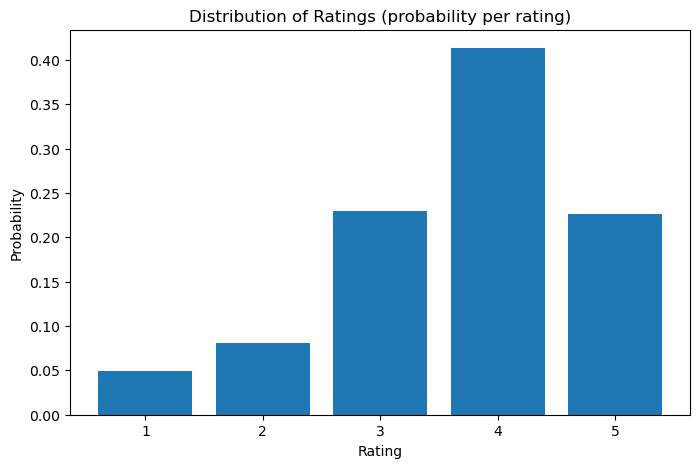

In [85]:



# Compute histogram
counts, _ = np.histogram(ratings['rating'], bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5])
# Convert counts to probabilities
probs = counts / counts.sum()

# Plot the distribution
fig, ax = plt.subplots(figsize=(8,5))
# Create bar plot for x axis values 1 to 5
x = np.arange(1, 6)
ax.bar(x, probs)
ax.set_xlabel('Rating')
ax.set_ylabel('Probability')
ax.set_title('Distribution of Ratings (probability per rating)')
plt.show()

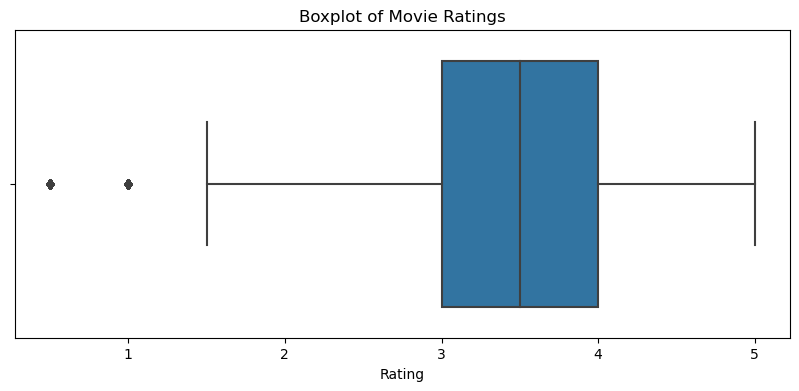

Q1=3.00, Q3=4.00, IQR=1.00
Lower bound=1.50, Upper bound=5.50


In [86]:
# Boxplot of ratings and identification of outliers 
#We first plot the boxplot of the ratings 

plt.figure(figsize=(10,4))
#we call the function boxplot from seaborn, the libray was already imported in the first cell of the notebook so I understand I can use it directly
ax = sns.boxplot(x=ratings['rating'])

ax.set_title('Boxplot of Movie Ratings')
ax.set_xlabel('Rating')
plt.show()

# Now we compute IQR-based outlier bounds, and identify outlier ratings. To do so we compute the quantiles Q1 and Q3
# and then the difference IQR. Finally we compute the lower and upper bounds for outliers
q1 = ratings['rating'].quantile(0.25)
q3 = ratings['rating'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

#the outliers are the ratings that are below the lower bound or above the upper bound
outliers_df = ratings[(ratings['rating'] < lower_bound) | (ratings['rating'] > upper_bound)]

print(f"Q1={q1:.2f}, Q3={q3:.2f}, IQR={iqr:.2f}")
print(f"Lower bound={lower_bound:.2f}, Upper bound={upper_bound:.2f}")



By the distribution of the ratings we can notice that on average the movies are rated witt 3 or 4 stars, that there are a very few in comparison of all the movies that have only 1 star. On the other hand we also notice that the majority goes to 4 stars. In the boxplot we can notice the outliers and the upper and lowe bounds, there can be no upper outliers sine the upper bound is above 5. The outliers are films that have a lower rating than 1.50

In [87]:
# We create two new df to store good and bad ratings, they are created from the ratings df but now only contain ratings >4.0 and <2.0 respectively
good_ratings = ratings[ratings['rating'] > 4.0]
bad_ratings = ratings[ratings['rating'] < 2.0]

# We count the more frequent movies in both good and bad ratings,these functions were also hinted at in the statement
good_counts = good_ratings['movie_id'].value_counts().nlargest(10)
bad_counts = bad_ratings['movie_id'].value_counts().nlargest(10)

# we need to know the title because right now we only have the movie_id and we are interested in the movie title
# so we convert to dataframe to be able to merge with movies
good_counts = good_counts.reset_index()
bad_counts = bad_counts.reset_index()

good_counts.columns = ['movie_id', 'good_ratings']
bad_counts.columns = ['movie_id', 'bad_ratings']

# Now we can use the merge df function to get the titles, using as common column movie_id
good_counts = good_counts.merge(movies[['movie_id', 'title']], on='movie_id')
bad_counts = bad_counts.merge(movies[['movie_id', 'title']], on='movie_id')

# and now we print the results
print("Top 10 movies with most good ratings (>4.0):")
for _, row in good_counts.iterrows():
    print(f"movie_id: {row['movie_id']}, title: {row['title']}, good ratings: {row['good_ratings']}")

print("\nTop 10 movies with most bad ratings (<2.0):")
for _, row in bad_counts.iterrows():
    print(f"movie_id: {row['movie_id']}, title: {row['title']}, bad ratings: {row['bad_ratings']}")


Top 10 movies with most good ratings (>4.0):
movie_id: 4993, title: Lord of the Rings: The Fellowship of the Ring, The (2001), good ratings: 4066
movie_id: 7153, title: Lord of the Rings: The Return of the King, The (2003), good ratings: 3815
movie_id: 5952, title: Lord of the Rings: The Two Towers, The (2002), good ratings: 3669
movie_id: 4226, title: Memento (2000), good ratings: 2769
movie_id: 3578, title: Gladiator (2000), good ratings: 2369
movie_id: 4973, title: Amelie (Fabuleux destin d'AmÃ©lie Poulain, Le) (2001), good ratings: 2274
movie_id: 7361, title: Eternal Sunshine of the Spotless Mind (2004), good ratings: 2252
movie_id: 5618, title: Spirited Away (Sen to Chihiro no kamikakushi) (2001), good ratings: 2072
movie_id: 6874, title: Kill Bill: Vol. 1 (2003), good ratings: 1903
movie_id: 48516, title: Departed, The (2006), good ratings: 1787

Top 10 movies with most bad ratings (<2.0):
movie_id: 5378, title: Star Wars: Episode II - Attack of the Clones (2002), bad ratings: 42

We can see that The Lord of the Rings trilogy appears in both the good and bad ratings lists. This suggests that these movies are very popular and generate a lot of debate about whether they are good or not. In general, we find well-known movies in both top 10s. For example, in the bad ratings list, there are also Star Wars films, which tend to cause a lot of controversy.

These ratings are very personal — in my case, The Lord of the Rings trilogy is among my favorite movies, so I would rate them very highly, but there are people who might disagree. It is interesting that all the films listed come from the 2000–2005 period,maybe  there were more criticss.

## 2.2. Genres distribution

In [88]:
# We first split the 'genres' strings into individual genres and then explode the lists into separate rows.
all_genres = movies['genres'].str.split('|').explode().unique()

# We then create a DataFrame to show them  as a table
genres_table = pd.DataFrame(all_genres, columns=['Genre'])

display(genres_table)
assert len(all_genres) == 20


,Genre
0,Crime
1,Drama
2,Comedy
3,Adventure
4,Sci-Fi
5,Thriller
6,Romance
7,Horror
8,Mystery
9,Action


In [89]:
#We define a function that calculates, for each genre, the number of movies and the average rating, this function
#takes as input the movies dataframe, the name of the column that contains the genres, a list of all genres and the ratings dataframe
#and returns a dataframe with the genre, the count of movies and the average rating
def calc_genre_count_avg_rating(movies_df, genres_col, all_genres, ratings_df):
    
    
    #we first copy the movies dataframe to avoid modifying the original one
    m = movies_df.copy()
    #we fillna to avoid errors when splitting and converting to string
    m[genres_col] = m[genres_col].fillna('').astype(str)
    #it can happen that a movie has multiple genres, separated by '|', so we split the string and explode the list into separate rows
    m = m.assign(genre=m[genres_col].str.split('|')).explode('genre')
    #we group by genre and count the number of unique movie_id for each genre
    movie_counts = m.groupby('genre')['movie_id'].nunique()

    #we then copy the ratings dataframe to avoid modifying the original one
    r = ratings_df.copy()
    #we fillna to avoid errors when splitting and converting to string
    r['genres'] = r['genres'].fillna('').astype(str)
    #we split the genres string and explode the list into separate rows
    r = r.assign(genre=r['genres'].str.split('|')).explode('genre')
    #we group by genre and calculate the average rating for each genre
    avg_ratings = r.groupby('genre')['rating'].mean()

    # Build result df using all_genres as index
    result = pd.DataFrame({'genre': list(all_genres)})
    result['count'] = result['genre'].map(movie_counts).fillna(0).astype(int)
    result['avg_rating'] = result['genre'].map(avg_ratings)
    result['avg_rating'] = result['avg_rating'].round(2)

    result = result.sort_values('count', ascending=False).reset_index(drop=True)
    return result

In [90]:
# LEAVE THIS CODE AS-IS

genre_count_avg_rating = calc_genre_count_avg_rating(movies, 'genres', all_genres, ratings)
genre_count_avg_rating

,genre,count,avg_rating
0,Drama,20069,3.63
1,Comedy,13384,3.35
2,Thriller,8079,3.51
3,Documentary,7583,3.60
4,Romance,5990,3.51
5,Horror,5574,3.16
6,Action,5561,3.43
7,Crime,3538,3.60
8,(no genres listed),3320,NaN
9,Sci-Fi,2921,3.40




We can see by our output that the genre that appears the most is drama followed by comedy and thriller. The genre that appears the least is film-noir with only 21 appearances. Horror is the genre with the lowest avg rating. It might be because it ismore dificult to produce a great horror movie, or at least more dificult than an action movie. The movie with the highest  average rating is Film -Noir .This might be because of the low number of ratings that has, if maybe more people rated film-noir movies, the avg would be lower.

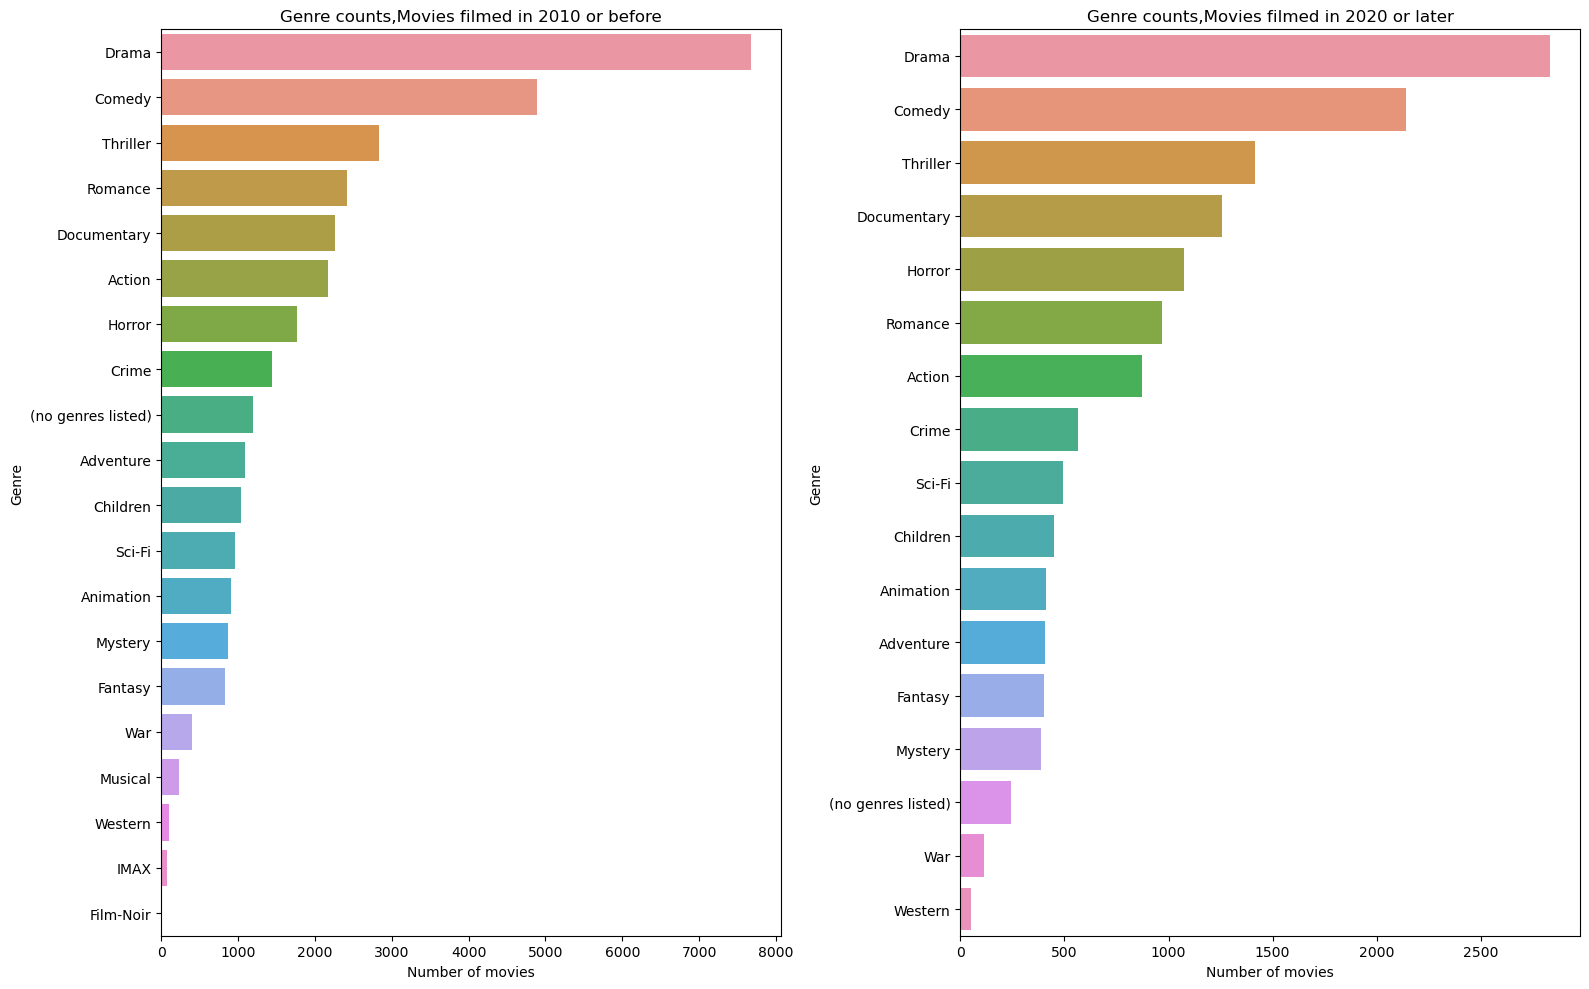

In [91]:
# We first create two different subset movies by year release
movies_pre2010 = movies[movies['year'] <= 2010]
movies_2020plus = movies[movies['year'] >= 2020]

# We split and explode genres (since one movie can have multiple genres)
movies_pre2010_exp = movies_pre2010.assign(genre=movies_pre2010['genres'].str.split('|')).explode('genre')
# The same for movies 2020 +
movies_2020plus_exp = movies_2020plus.assign(genre=movies_2020plus['genres'].str.split('|')).explode('genre')

# We then count how many movies belong to each genre
gc_pre2010 = movies_pre2010_exp['genre'].value_counts().reset_index()
#And rename columns for clarity
gc_pre2010.columns = ['genre', 'count']
#and the same for movies 2020 +
gc_2020 = movies_2020plus_exp['genre'].value_counts().reset_index()
gc_2020.columns = ['genre', 'count']

# Now we plot the results using the hint given by the statement, the sns library to create the bar plots
fig, axes = plt.subplots(1, 2, figsize=(16, 10))

# Pre-2010 movies, we order the bars by genre count so the plot looks better
sns.barplot(data=gc_pre2010,x='count',y='genre',ax=axes[0],order=gc_pre2010['genre'])
axes[0].set(title='Genre counts,Movies filmed in 2010 or before',xlabel='Number of movies',ylabel='Genre')

# 2020+ movies
sns.barplot(data=gc_2020,x='count',y='genre',ax=axes[1],order=gc_2020['genre'])
axes[1].set(title='Genre counts,Movies filmed in 2020 or later',xlabel='Number of movies',ylabel='Genre')

#we tighten the layout because the titles were overlapping with the plots, i found this command online
plt.tight_layout()
plt.show()


We can see that the genres that appear the most are the same in both barplots, the three genres with the most appearences are the same: Drama,Comedy and thriller. 
Film-Noir doesn't appear on the second boxplot, so no appearances from the 2020. In general, the number of appearances in the 202's is way lower than in the 2010's, we can notice by the scales of the barplots. For example, the comedy films in the 2020's is around 2000 and in the 2010's is near 5000. This decrease of appearances happens with all the genres

# 3. Content-based recommendation

### 3.1. Compute TF-IDF vectors

In [92]:
# We add a column with genres as a list, ensuring no NaN values
#fillna is used to replace NaN values with an empty string, then we convert to string type
# and finally we split the string by '|' to create a list of genres for each movie using the apply function

movies['genres_arr'] = movies['genres'].fillna('').astype('str').apply(lambda s: s.split('|') if s else [])

In [93]:
# LEAVE THIS CODE AS-IS

print("Transformed: %s → %s" % (movies['genres'][3], movies['genres_arr'][3]))

Transformed: Adventure|Sci-Fi|Thriller → ['Adventure', 'Sci-Fi', 'Thriller']


In [94]:
# LEAVE THIS CODE AS-IS

# The reset-index is important to match row/column numbers in the tdifd-matrix

movies_filtered = movies[movies.year >= 2020]
movies_filtered = movies_filtered.reset_index()
display(movies_filtered.head(5))

,index,movie_id,title,genres,year,genres_arr
0,34111,209311,Waves (2020),Drama|Romance,2020,"[Drama, Romance]"
1,34403,210455,Gretel & Hansel (2020),Fantasy|Horror|Thriller,2020,"[Fantasy, Horror, Thriller]"
2,34409,210469,Like a Boss (2020),Comedy,2020,[Comedy]
3,34431,210569,Birds of Prey (And the Fantabulous Emancipatio...,Action|Adventure|Crime,2020,"[Action, Adventure, Crime]"
4,34432,210571,Fantasy Island (2020),Fantasy|Horror|Sci-Fi,2020,"[Fantasy, Horror, Sci-Fi]"


In [95]:
    
tfidf_matrix = TfidfVectorizer(analyzer='word', ngram_range=(1, 2)).fit_transform(movies_filtered['genres'].fillna(''))
tfidf_matrix.shape


(7986, 128)

## 3.2. Calculate most similar movies

In [96]:
# LEAVE THIS CODE AS-IS

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
print(cosine_sim)

[[1.         0.         0.         ... 0.15629465 0.37012241 0.        ]
 [0.         1.         0.         ... 0.         0.         0.        ]
 [0.         0.         1.         ... 0.48040741 0.         0.        ]
 ...
 [0.15629465 0.         0.48040741 ... 1.         0.42227826 0.        ]
 [0.37012241 0.         0.         ... 0.42227826 1.         0.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]]


In [97]:
# LEAVE THIS CODE AS-IS

# Create an index to convert from numbers to movie_id
movie_id_to_index = pd.Series(movies_filtered.index, index=movies_filtered['movie_id'])

# Print the similarity vector
def print_similarity_vector(movie_id, similarities):
    
    # Determine the index of the movie_id
    index_source = movie_id_to_index[movie_id]
    
    # Get the row in the similarities matrix
    sim_scores = list(similarities[index_source])

    # Iterate through that row
    for index_target in range(len(sim_scores)):
        print("%.3f %d %s" %
              (sim_scores[index_target], movies_filtered.iloc[index_target].movie_id, movies_filtered.iloc[index_target].title))

# Test with the movie: "Gretel & Hansel (2020)"
print_similarity_vector(210455, cosine_sim)

0.000 209311 Waves (2020)
1.000 210455 Gretel & Hansel (2020)
0.000 210469 Like a Boss (2020)
0.000 210569 Birds of Prey (And the Fantabulous Emancipation of One Harley Quinn) (2020)
0.556 210571 Fantasy Island (2020)
0.000 210573 The King's Man (2020)
0.000 210575 The Photograph (2020)
0.108 210577 Sonic the Hedgehog (2020)
0.000 210579 What About Love (2020)
0.132 210847 Bloodshot (2020)
0.000 210849 The Call of the Wild (2020)
0.000 210851 Emma (2020)
0.000 210853 My Boyfriend's Meds (2020)
0.075 210855 The Rhythm Section (2020)
0.641 210857 The Turning (2020)
0.296 210859 Run (2020)
0.000 210861 The Gentlemen (2020)
0.187 210863 Dolittle (2020)
0.089 210865 Bad Boys for Life (2020)
0.131 210867 Underwater (2020)
0.000 210869 My Spy (2020)
0.000 210873 Invasion (2020)
0.000 211141 Echo (2020)
0.137 211223 The Grudge (2020)
0.000 211391 Downhill (2020)
0.000 211428 Ana (2020)
0.000 211504 Rogue Warfare: Death of a Nation (2020)
0.000 211540 Tolo Tolo (2020)
0.153 211544 De kuthoer (2

In [98]:

#The template given by the statement helps us to define this function
#that takes as input a movie_id, the movies dataframe, the similarities matrix 
#and returns a dataframe with the top-K recommended movies based on genre similarity
def genre_content_based_recommendations(movie_id, movies, similarities, num_movies):
    

    index_source = movie_id_to_index[movie_id]
    #we create a list of similarity scores for the source movie
    sim_scores = list(similarities[index_source])

    # we enumerate the similarity scores to keep track of the movie indices
    enumerated = list(enumerate(sim_scores))
    # we sort the enumerated list by similarity score in descending order
    sorted_similarities = sorted(enumerated, key=lambda x: x[1], reverse=True)

    # We exclude the source movie itself and pick top-K
    top_similarities = [pair for pair in sorted_similarities if pair[0] != index_source][:num_movies]

    recommendations = []
    
    for (index_target, similarity) in top_similarities:
        # We obtain the recommended movie info from the provided movies DataFrame
        row = movies.iloc[index_target]
        rec_movie_id = int(row['movie_id'])
        title = row.get('title', '')
        genres = row.get('genres', '')
        recommendations.append({
            'movie_id': int(movie_id),
            'recom_movie_id': rec_movie_id,
            'similarity': float(similarity.round(2)),
            'title': title,
            'genres': genres
        })
    # we return a dataframe with the recommendations
    return pd.DataFrame.from_records(recommendations,columns=['movie_id', 'recom_movie_id', 'similarity', 'title', 'genres'])

In [99]:
#We store the tittles of the two movies we want to get recommendations for
titles = ["Oxygen (2021)", "PAW Patrol: The Movie (2021)"]

#in this case I will define a function that given a title returns the movie_id,takes as input the title and the movies dataframe
#and returns the movie_id if found, otherwise None
def get_movie_id_by_title(title, df):
    res = df[df['title'] == title]
    if not res.empty:
        return int(res.iloc[0]['movie_id'])
    else:
        return None
#for each movie 
for t in titles:
    #we get the movie_id using the function defined above
    mid = get_movie_id_by_title(t, movies_filtered)
    if mid is None:
        print(f"Movie not found in filtered set: {t}\n")
        continue
    print(f"Top 10 recommendations for \"{t}\" (movie_id={mid}):")
    #we call the recommendation function defined above and print the results
    recs = genre_content_based_recommendations(mid, movies_filtered, cosine_sim, num_movies=10)
    for _, r in recs.iterrows():
        print(f"  recom_movie_id={int(r['recom_movie_id'])}, similarity={r['similarity']:.3f}, title={r['title']}, genres={r['genres']}")
    print()

Top 10 recommendations for "Oxygen (2021)" (movie_id=249122):
  recom_movie_id=276817, similarity=0.900, title=Nothing Else (2021), genres=Fantasy|Sci-Fi|Thriller
  recom_movie_id=278418, similarity=0.900, title=Memory of Water (2022), genres=Fantasy|Sci-Fi|Thriller
  recom_movie_id=227258, similarity=0.890, title=The Midnight Sky (2020), genres=Drama|Fantasy|Sci-Fi
  recom_movie_id=268802, similarity=0.890, title=I Am Mortal (2022), genres=Drama|Fantasy|Sci-Fi
  recom_movie_id=278654, similarity=0.890, title=Kanam (2022), genres=Drama|Fantasy|Sci-Fi
  recom_movie_id=260645, similarity=0.830, title=It's a Summer Film! (2021), genres=Comedy|Drama|Fantasy|Sci-Fi
  recom_movie_id=210847, similarity=0.790, title=Bloodshot (2020), genres=Action|Drama|Fantasy|Sci-Fi
  recom_movie_id=278080, similarity=0.790, title=Samaritan (2022), genres=Action|Drama|Fantasy|Sci-Fi
  recom_movie_id=225565, similarity=0.780, title=Spontaneous (2020), genres=Fantasy|Sci-Fi
  recom_movie_id=230769, similarity=

In [100]:

#I first define a list with the titles of the movies I want to get recommendations for
my_movies = [ "Underwater (2020)", "The Gentlemen (2020)", "Run (2020)" ]

#As my genre_content_based_recommendations function takes as input the movie_id i will create a function that given a title returns the movie_id
#takes as input the title and the movies dataframe

def get_movie_id_by_title(title, df):
    res = df[df['title'] == title]
    if not res.empty:
        return int(res.iloc[0]['movie_id'])
    else:
        return None
#I store the movie_ids corresponding to the titles in my_movies
movies_ids = [get_movie_id_by_title(title, movies_filtered) for title in my_movies]

num_recs = 15
precision_scores = []
#Now I can get the recommendations for each movie in my_movies
for mid in movies_ids:
    #if not found
    if mid is None:
        print(f"Movie not found in filtered set: {t}\n")
        continue

    print(f"Top 15 recommendations for movie = {my_movies[movies_ids.index(mid)]}:")
    #I call the recommendation function defined above and print the results, the id of the movie is mid
    recs = genre_content_based_recommendations(mid, movies_filtered, cosine_sim, num_movies=15)
    #We display the results, the output of the function is a dataframe so we can use the display function
    display(recs[['title', 'genres', 'similarity']])
    #Now I manually define the relevance vector based on my judgement of the recommendations
    if my_movies[movies_ids.index(mid)] == "Underwater (2020)":
        relevance_manual = [1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0]
    elif my_movies[movies_ids.index(mid)] == "The Gentlemen (2020)":
        relevance_manual = [1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0]
    else:
        relevance_manual = [1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1]
    recs['relevance_manual'] = relevance_manual
    #I compute  the precision as the statement says
    precision = sum(relevance_manual) / num_recs
    precision_scores.append(precision)
    print(f"Precision for '{my_movies[movies_ids.index(mid)]}': {precision:.2f}")
    print()
#and now I print the average precision across all movies
average_precision = sum(precision_scores) / len(precision_scores)
print(f"\nAverage Precision across all movies: {average_precision:.2f}")




Top 15 recommendations for movie = Underwater (2020):


,title,genres,similarity
0,Tremors: Shrieker Island (2020),Action|Horror,1.00
1,Spare Parts (2020),Action|Horror,1.00
2,RIP: Rest in Pieces (2020),Action|Horror,1.00
3,616 Wilford Lane (2021),Action|Horror,1.00
4,The Manson Brothers Midnight Zombie Massacre (...,Action|Horror,1.00
5,Jurassic Shark 2: Aquapocalypse (2021),Action|Horror,1.00
6,Death Valley (2021),Action|Horror,1.00
7,Megaboa (2021),Action|Horror,1.00
8,Exorcist Vengeance (2022),Action|Horror,1.00
9,The Retaliators (2022),Action|Horror,1.00


Precision for 'Underwater (2020)': 0.53

Top 15 recommendations for movie = The Gentlemen (2020):


,title,genres,similarity
0,Disturbing the Peace (2020),Action|Crime,1.0
1,Bad Boy (2020),Action|Crime,1.0
2,Deliver Us from Evil (2020),Action|Crime,1.0
3,Shock Wave 2 (2020),Action|Crime,1.0
4,Krack (2021),Action|Crime,1.0
5,Wrath of Man (2021),Action|Crime,1.0
6,Jagame Thandhiram (2021),Action|Crime,1.0
7,Attraction to Paris (2021),Action|Crime,1.0
8,Raging Fire (2021),Action|Crime,1.0
9,Rattlesnake: The Ahanna Story (2020),Action|Crime,1.0


Precision for 'The Gentlemen (2020)': 0.47

Top 15 recommendations for movie = Run (2020):


,title,genres,similarity
0,Escape from Pretoria (2020),Thriller,1.0
1,Alone (2020),Thriller,1.0
2,A Fall From Grace (2020),Thriller,1.0
3,The Intruder (2020),Thriller,1.0
4,The Decline (2020),Thriller,1.0
5,Impossible Monsters (2020),Thriller,1.0
6,Wasp Network (2020),Thriller,1.0
7,Dangerous Lies (2020),Thriller,1.0
8,Skinned (2020),Thriller,1.0
9,M.O.M. Mothers of Monsters (2020),Thriller,1.0


Precision for 'Run (2020)': 0.60


Average Precision across all movies: 0.53


### Extra features:
Currently, the recommendations are based only on the genres of the movies. We could improve recomending  by adding  other features such as actors, directors, keywords .... Two movies in the same genre might still feel very different.

### Weight genres:
Not all genres are equally important for every user. We could weight genres differently based on the user’s past ratings. Similarly, we could use a similar approach like on  TF-IDF on  keywords so that unique or distinguishing features contribute more to the similarity score.

<font size="+2" color="#003300">I hereby declare that I completed this practice myself, that my answers were not written by an AI-enabled code assistant, and that except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>